### Time-series model

- modèle [Autoformer](https://huggingface.co/blog/autoformer)
- modèle [Time Series Transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer)
- modèle [Informer](https://huggingface.co/blog/informer)
- modèle [Sk Forecast](https://huggingface.co/blog/skforecast)

In [20]:
# Import all data visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import ipywidgets as ipy
from IPython.display import Image

sns.set_theme()
sns.set_palette("colorblind")
sns.set_style('whitegrid')
plt.tight_layout()
%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('data/output_data.csv', parse_dates = ['date'])
df = df.set_index('date')
df = df.asfreq('B')

df = df.sort_index()

start_train = '2017-08-01'
end_train = '2022-09-01'
start_test = '2022-09-01'
end_test = '2023-05-01'
timedelta_test = datetime.strptime(end_test, '%Y-%m-%d') - datetime.strptime(start_test, '%Y-%m-%d')
 
# Split dataset in date between 08-2017 to 08-2022 and testing fom 09-2022 to 04-2023

X_train = df.loc[start_train:end_train]
X_test = df.loc[start_test:end_test]

X_train.shape, X_test.shape
df['Close_BTC'].isna().sum()

0

In [22]:
# Extract all column name starting by 'close'
targets = [col for col in df.columns if col.startswith('Close')]
targets

['Close_BTC',
 'Close_ETH',
 'Close_DOGE',
 'Close_SHIB',
 'Close_DOT',
 'Close_BCH',
 'Close_SOL',
 'Close_ADA',
 'Close_MATIC',
 'Close_BNB',
 'Close_LTC',
 'Close_XRP']

### Preprocessing

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

### Infinites values

In [24]:
def replace_infinities(X):
    return X.replace([np.inf, -np.inf], np.nan)

replace_infinities_transformer = FunctionTransformer(replace_infinities)


### 0 standard deviation

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class RemoveZeroStdColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.zero_std_mask_ = np.std(X, axis=0) != 0
        return self

    def transform(self, X, y=None):
        return X[:, self.zero_std_mask_]

### Outliers

In [26]:
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt

def plot(column):
    if df[column].dtype in ['int64', 'float64']:
        sns.boxplot(x=df[column])
    else:
        sns.countplot(x=df[column])
    plt.show()

interact(plot, column=df.columns.tolist())

interactive(children=(Dropdown(description='column', options=('btc_tweet_count', 'eth_tweet_count', 'bnb_tweet…

<function __main__.plot(column)>

In [27]:
# To write a function to handle outliers

### Missing data

In [28]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Get all col containing missing values
na_cols = [col for col in X_train.columns if X_train[col].isna().sum() > 0]
imputer = KNNImputer()

print(len(na_cols))

153


### Numerical data

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [30]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Numeric columns : {len(numeric_columns)}')

Numeric columns : 200


### No categorical data

#### Preprocessing pipeline 

In [31]:
std = StandardScaler()
pca = PCA(n_components=70)
inf_col = [col for col in X_train.columns if X_train[col].isin([np.inf, -np.inf]).sum() > 0]
print(len(inf_col))
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(len(numeric_columns))

preprocessor = Pipeline(steps=[
    # ('outlier', outlier_remover),
    ('replace_infinities', replace_infinities_transformer),
    ('imputer', imputer),
    ('remove_zero_std', RemoveZeroStdColumns()),
    ('scaler', std),
    ('pca', pca)
])

preprocessor

0
200


Pipeline(steps=[('replace_infinities',
                 FunctionTransformer(func=<function replace_infinities at 0x28437e840>)),
                ('imputer', KNNImputer()),
                ('remove_zero_std', RemoveZeroStdColumns()),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=70))])

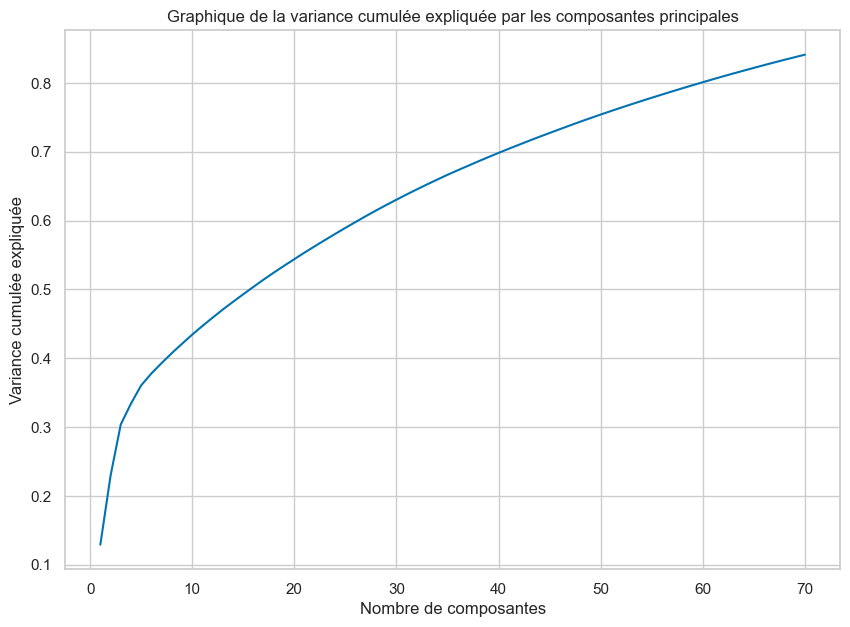

In [32]:
import matplotlib.pyplot as plt

# Entraîner le préprocesseur
preprocessor.fit(X_train)

# Obtenir la variance expliquée par les composantes principales
explained_variance = preprocessor.named_steps['pca'].explained_variance_ratio_

# Calculer la variance cumulée expliquée
cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un graphique de la variance cumulée expliquée
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Graphique de la variance cumulée expliquée par les composantes principales')
plt.grid(True)
plt.show()

In [33]:
A = preprocessor.fit_transform(X_train)
print(X_train.shape, A.shape)

# NaNs?
print(np.isnan(A).sum())
# Infs?
print(np.isinf(A).sum())

(1316, 200) (1316, 70)
0
0


### Model : SARIMAX

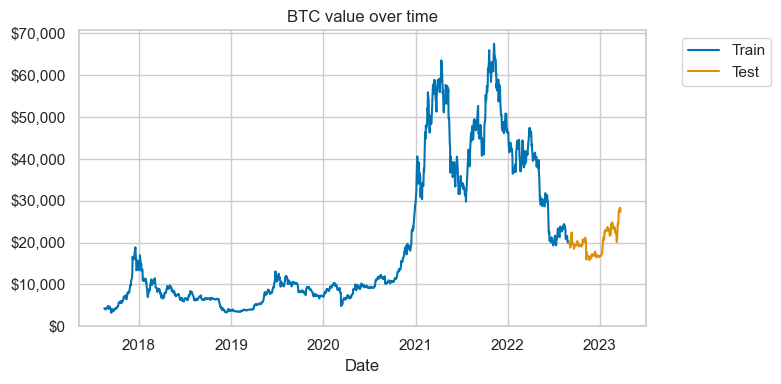

In [34]:
fig, ax = plt.subplots(figsize=(8, 4)) 
sns.lineplot(data = X_train, x = X_train.index, y = 'Close_BTC', ax=ax, label='Train')
sns.lineplot(data = X_test, x = X_test.index, y = 'Close_BTC', ax=ax, label='Test')

# Améliorer les étiquettes de date
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Format y axis as $
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Ajouter des étiquettes d'axe
ax.set_xlabel('Date')
ax.set_ylabel('')

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

ax.set_title('BTC value over time')

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
    
y_train = X_train[targets[0]]
y_test = X_test[targets[0]]

X_train = X_train.drop(targets[0], axis=1)
X_test = X_test.drop(targets[0], axis=1)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Créer le modèle de prévision
model = SARIMAX(y_train, X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Entraîner le modèle
model_fit = model.fit()

# Faire des prévisions
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {rmse}')

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46313D+00    |proj g|=  6.28895D-02

At iterate    5    f=  8.43639D+00    |proj g|=  1.35426D-02

At iterate   10    f=  8.43363D+00    |proj g|=  3.55445D-04

At iterate   15    f=  8.43357D+00    |proj g|=  1.87301D-03

At iterate   20    f=  8.40808D+00    |proj g|=  1.61957D-01

At iterate   25    f=  8.33597D+00    |proj g|=  4.27857D-03

At iterate   30    f=  8.33588D+00    |proj g|=  5.39676D-04

At iterate   35    f=  8.33188D+00    |proj g|=  1.07894D-02

At iterate   40    f=  8.33058D+00    |proj g|=  2.47673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RMSE: 2909.5485489751995


<Axes: xlabel='date', ylabel='Close_BTC'>

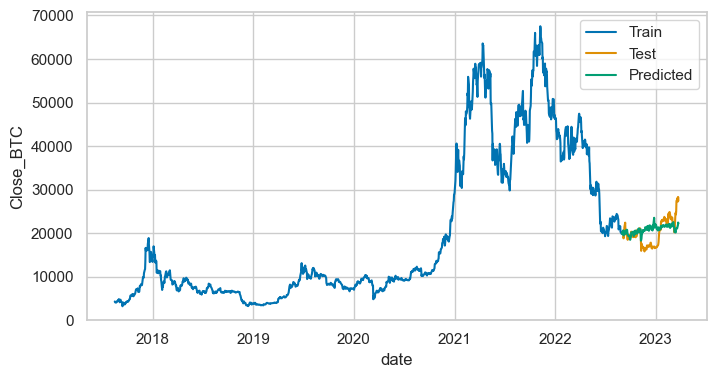

In [36]:
# Plot the train, test and predicted values
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(data = pd.DataFrame(y_train), x = y_train.index, y = y_train, ax=ax, label='Train')
sns.lineplot(data = pd.DataFrame(y_test), x = y_test.index, y = y_test, ax=ax, label='Test')
sns.lineplot(data = pd.DataFrame(y_pred), x = y_test.index, y = y_pred, ax=ax, label='Predicted')

### Model 2

In [37]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


import plotly.graph_objs as go


X_train_prophet = X_train[targets[0]].reset_index()
X_train_prophet.columns = ['ds', 'y']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/mathisderenne/Mon Drive/04 - 

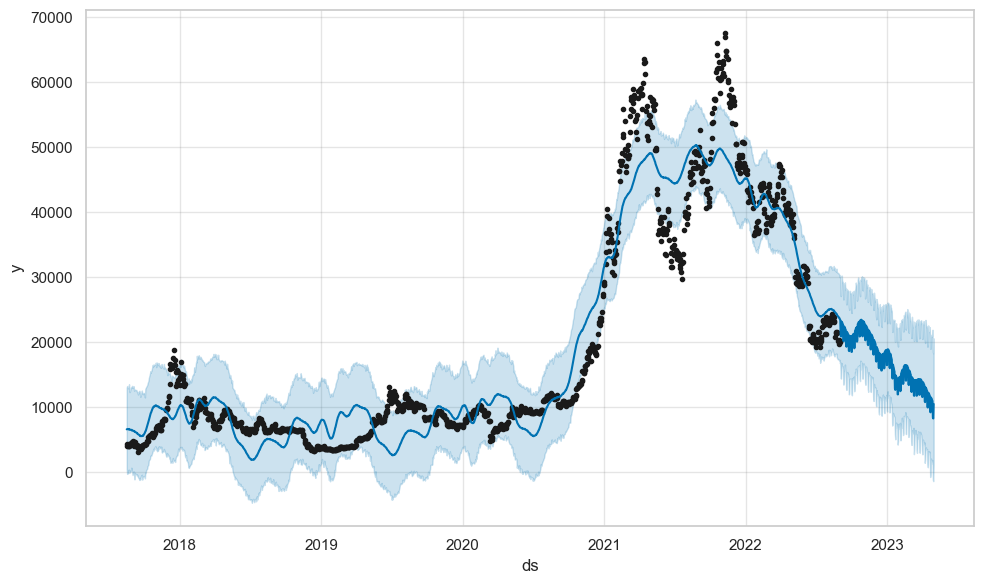

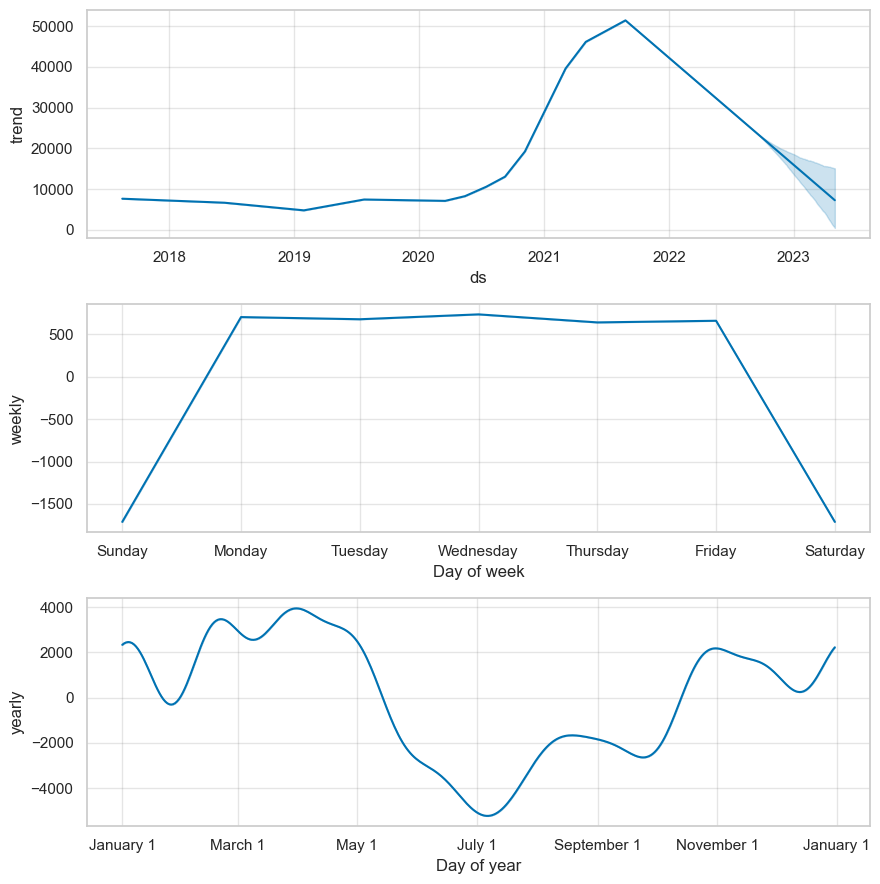

In [ ]:
m = Prophet()
m.fit(X_train_prophet)
X_pred_prophet = m.make_future_dataframe(periods = timedelta_test.days)
X_pred_prophet = m.predict(X_pred_prophet)
fig1 = m.plot(X_pred_prophet)
fig2 = m.plot_components(X_pred_prophet)

In [ ]:
plot_plotly(m, X_pred_prophet)

In [ ]:
plot_components_plotly(m, X_pred_prophet)

In [ ]:
X_test[targets[0]]

date
2022-09-01    20131.46
2022-09-02    19951.86
2022-09-05    19796.84
2022-09-06    18790.61
2022-09-07    19292.84
                ...   
2023-03-20    27717.01
2023-03-21    28105.47
2023-03-22    27250.97
2023-03-23    28295.41
2023-03-24    27454.47
Freq: B, Name: Close_BTC, Length: 147, dtype: float64

In [ ]:
# Compute RMSE of prophet prediction
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(X_test[targets[0]], X_pred_prophet['yhat'].tail(147)))
rmse

7160.055432321778